---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**

----------------

## The Traveling Sales(man)(person) Problem — TSP
### Integrating `pysal/spaghetti` and [pulp](https://github.com/coin-or/pulp) for optimal routing

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook provides a use case for:**

1. Introducing the TSP
2. Declaration of a solution class and model parameters
3. Solving the TSP for an optimal tour

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext watermark
%watermark

Last updated: 2021-06-28T19:35:22.152252-04:00

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
import geopandas
from libpysal import examples
import matplotlib
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pulp
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.2.0

spaghetti          : 1.6.2
pulp               : 2.4
libpysal           : 4.4.0
numpy              : 1.20.3
json               : 2.0.9
matplotlib_scalebar: 0.7.2
matplotlib         : 3.4.2
geopandas          : 0.9.0



-----------------------------

### 1 Introduction
#### Scenario
Detective George B. Königsberg thought he needed to visit **7** crimes scenes in one area of City X this afternoon in order to collect evidence. However, his lieutenant, Anna Nagurney just told him he needs to double that to **14**. He really wants to wrap up early so he can get home to watch the 2012 mathematical thriller, [Travelling Salesman by Timothy Lanzone](https://en.wikipedia.org/wiki/Travelling_Salesman_(2012_film)), with his cat and dog, Euler and Hamilton. Therefore, he decides on calculating an optimal route so that he can visit all **14** crime scenes in one tour while covering the shortest distance. Det. Königsberg utilizes an integer linear programming formulation of the traveling salesperson problem (TSP) to find his best route.

--------------------------------

#### Integer Linear Programming Formulation based on Miller, Tucker, and Zemlin (1960).

$\begin{array}
\displaystyle \normalsize \textrm{Minimize} & \displaystyle \normalsize \sum_{0 \leq i \\ i \neq j}^n \sum_{j \leq n \\ j \neq i}^n c_{ij}x_{ij}  & & & &  \normalsize (1) \\
\normalsize \textrm{Subject To} & \displaystyle \normalsize \sum_{i=0}^n x_{ij}=1 & \normalsize j=1,...,n, & \normalsize j\neq i;  & &\normalsize (2)\\
& \displaystyle \normalsize \sum_{j=0}^n x_{ij}=1 & \normalsize i=1,...,n, & \normalsize i\neq j; & &\normalsize (3) \\
& \displaystyle \normalsize u_i - u_j + p x_{ij} \leq p - 1 & \normalsize i=1,...,n, & \normalsize 1 \leq i \neq j \leq n; & &\normalsize (4) \\
& \normalsize x_{ij} \in \{0,1\} & \normalsize i=1,...,n, & \normalsize j=1,...,n; & &\normalsize (5)\\
& \normalsize u_{i} \in \mathbb{Z} & \normalsize i=1,...,n. & & &\normalsize (6)\\
\end{array}$

$\begin{array}
\displaystyle \normalsize \textrm{Where} & \small x_{ij} & \small = & \small \begin{cases}
    1, & \textrm{if node } i \textrm{ immediately precedes node } j \textrm{ in the tour}\\
    0, & \textrm{otherwise}
  \end{cases} &&&&\\
& \small c_{ij} & \small = & \small \textrm{distance matrix between all } i,j \textrm{ pairs} &&&& \\
& \small n & \small = & \small \textrm{the total number of nodes in the tour} &&&&\\
& \small i & \small = & \small \textrm{each potential origin node} &&&&\\
& \small j & \small = & \small \textrm{each potential destination node} &&&&\\
& \small u_i & \small = & \small \textrm{continuous, non-negative real numbers} &&&&\\
& \small p & \small = & \small \textrm{allowed visits prior to return (}n = p \textrm{ in this formulation)}  &&&&\\
\end{array}$


---------------------------------

**References**

* **Cummings, N.** (2000) [*A brief History of the Travelling Salesman Problem*](https://www.theorsociety.com/about-or/or-methods/heuristics/a-brief-history-of-the-travelling-salesman-problem/). The Operational Research Society. Accessed: 01/2020.
* **Dantzig, G., Fulkerson, R., and Johnson, S.** (1954) *Solution of a Large-Scale Traveling-Salesman Problem*. Journal of the Operational Research Society of America. 2(4)393-410.
* **Flood, Merrill M.** (1956) *The Traveling-Salesman Problem*. 4(1)61-75.
* **Gass, S. I. and Assad, A. A.** (2005) *An Annotated Timeline of Operations Research: An Informal History*. Springer US.
* **Miller, C. E., Tucker, A. W., and Zemlin, R. A.** (1960) *Integer Programming Formulation of Traveling Salesman Problems*. Journal of Association for Computing Machinery. 7(4)326-329.
* **Miller, H. J. and Shaw, S.-L.** (2001) *Geographic Information Systems for Transportation: Principles and Applications*. New York. Oxford University Press.
* **Nemhauser, G. L. and Wolsey, L. A.** (1988) *Integer and Combinatorial Optimization*. John Wiley & Sons, Inc.

-------------------------------------

### 2. A model, data and parameters
#### Solution class

In [4]:
class MTZ_TSP:
    def __init__(self, nodes, cij, xij_tag="x_%s,%s", ui_tag="u_%s", display=True):
        """Instantiate and solve the Traveling Salesperson Problem (TSP)
        based the formulation from Miller, Tucker, and Zemlin (1960).
        
        Parameters
        ----------
        nodes : geopandas.GeoSeries
            All nodes to be visited in the tour.
        cij : numpy.array
            All-to-all distance matrix for nodes.
        xij_tag : str
            Tour decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        ui_tag : str
            Arbitrary real number decision variable names within the model.
            Default is 'u_%s' where %s indicates string formatting.
        display : bool
            Print out solution results.
        
        Attributes
        ----------
        nodes : geopandas.GeoSeries
            See description in above.
        p : int
            The number of nodes in the set.   
        rp_0n : range
            Range of node IDs in ``nodes`` from 0,...,``p``.
        rp_1n : range
            Range of node IDs in ``nodes`` from 1,...,``p``.
        id : str
            Column name for ``nodes``.
        cij : numpy.array
            See description in above.
        xij_tag : str
            See description in above.
        ui_tag : str
            See description in above.
        tsp : pulp.LpProblem
            Integer Linear Programming problem instance.
        xij : numpy.array
            Binary tour decision variables (``pulp.LpVariable``).
        ui : numpy.array
            Continuous arbitrary real number decision variables
            (``pulp.LpVariable``).
        cycle_ods : dict
            Cycle origin-destination lookup keyed by origin with
            destination as the value.
        tour_pairs : list
            OD pairs comprising each abstract tour arc.
        """

        # all nodes to be visited and the distance matrix
        self.nodes, self.cij = nodes, cij
        # number of nodes in the set
        self.p = self.nodes.shape[0]
        # full and truncated range of nodes (p) in the set
        self.rp_0n, self.rp_1n = range(self.p), range(1, self.p)
        # column name for node IDs
        self.id = self.nodes.name
        # alpha tag for decision and dummy variable prefixes
        self.xij_tag, self.ui_tag = xij_tag, ui_tag

        # instantiate a model
        self.tsp = pulp.LpProblem("MTZ_TSP", pulp.LpMinimize)
        # create and set the tour decision variables
        self.tour_dvs()
        # create and set the arbitraty real number decision variables
        self.arn_dvs()
        # set the objective function
        self.objective_func()
        # node entry constraints
        self.entry_exit_constrs(entry=True)
        # node exit constraints
        self.entry_exit_constrs(entry=False)
        # subtour prevention constraints
        self.prevent_subtours()
        # solve
        self.tsp.solve()
        # origin-destination lookup
        self.get_decisions(display=display)
        # extract the sequence of nodes to construct the optimal tour
        self.construct_tour()

    def tour_dvs(self):
        """Create the tour decision variables - eq (5)."""

        def _name(_x):
            """Helper for naming variables"""
            return self.nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [
                    pulp.LpVariable(self.xij_tag % (_name(i), _name(j)), cat="Binary")
                    for j in self.rp_0n
                ]
                for i in self.rp_0n
            ]
        )

        self.xij = xij

    def arn_dvs(self):
        """Create arbitrary real number decision variables - eq (6)."""
        ui = numpy.array(
            [pulp.LpVariable(self.ui_tag % (i), lowBound=0) for i in self.rp_0n]
        )

        self.ui = ui

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.tsp += pulp.lpSum(
            [
                self.cij[i, j] * self.xij[i, j]
                for i in self.rp_0n
                for j in self.rp_0n
                if i != j
            ]
        )

    def entry_exit_constrs(self, entry=True):
        """Add entry and exit constraints - eq (2) and (3)."""
        if entry:
            for i in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for j in self.rp_0n if i != j]) == 1
                )
        # exit constraints
        else:
            for j in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for i in self.rp_0n if i != j]) == 1
                )

    def prevent_subtours(self):
        """Add subtour prevention constraints - eq (4)."""
        for i in self.rp_1n:
            for j in self.rp_1n:
                if i != j:
                    self.tsp += (
                        self.ui[i] - self.ui[j] + self.p * self.xij[i, j] <= self.p - 1
                    )

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        cycle_ods = {}
        for var in self.tsp.variables():
            if var.name.startswith(self.ui_tag[0]):
                continue
            if var.varValue > 0:
                if display:
                    print("%s: %s" % (var.name, var.varValue))
                od = var.name.split("_")[-1]
                o, d = [int(tf) for tf in od.split(",")]
                cycle_ods[o] = d
        if display:
            print("Status: %s" % pulp.LpStatus[self.tsp.status])

        self.cycle_ods = cycle_ods

    def construct_tour(self):
        """Construct the tour."""
        tour_pairs = []
        for origin in self.rp_0n:
            tour_pairs.append([])
            try:
                tour_pairs[origin].append(next_origin)
                next_origin = self.cycle_ods[next_origin]
                tour_pairs[origin].append(next_origin)
            except NameError:
                next_origin = self.cycle_ods[origin]
                tour_pairs[origin].append(origin)
                tour_pairs[origin].append(next_origin)

        tour_pairs = {idx: sorted(tp) for idx, tp in enumerate(tour_pairs)}
        self.tour_pairs = tour_pairs

    def extract_tour(self, paths, id_col, leg_label="leg"):
        """Extract the tour (the legs in the journey) as a 
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.
        
        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all observations.
        id_col : str
            ID column name.
        leg_label : str
            Column name for the tour sequence. Default is 'leg'.
        
        Returns
        -------
        tour : geopandas.GeoDataFrame
            Optimal tour of ``self.nodes`` sequenced by ``leg_label`` that
            retains the original index of ``paths``.
        """

        paths[leg_label] = int
        # set label of journey leg for each OD pair.
        for leg, tp in self.tour_pairs.items():
            paths.loc[paths[id_col] == tuple(tp), leg_label] = leg

        # extract only paths in the tour
        tour = paths[paths[leg_label] != int].copy()
        tour.sort_values(by=[leg_label], inplace=True)

        return tour

#### Streets

In [5]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "esri:102649"
streets = streets.to_crs("epsg:2762")
streets.head()

,ID,Length,geometry
0,1.0,244.116229,"LINESTRING (222007.131 267348.711, 222007.159 ..."
1,2.0,375.974828,"LINESTRING (222006.951 267549.880, 222007.131 ..."
2,3.0,400.353405,"LINESTRING (221420.428 267804.889, 221411.402 ..."
3,4.0,660.000000,"LINESTRING (220875.116 268353.388, 220803.948 ..."
4,5.0,660.000000,"LINESTRING (220802.426 268398.824, 220917.000 ..."


#### Crimes

In [6]:
all_crimes = geopandas.read_file(examples.get_path("crimes.shp"))
all_crimes.crs = "esri:102649"
all_crimes = all_crimes.to_crs("epsg:2762")
all_crimes.head()

,POLYID2,POLYID,geometry
0,1,1,POINT (221868.432 266920.497)
1,2,2,POINT (220923.246 266933.298)
2,3,3,POINT (221709.326 266960.731)
3,4,4,POINT (221900.131 266962.255)
4,5,5,POINT (221750.169 266962.864)


#### Detective Königsberg's cases

In [7]:
numpy.random.seed(1960)
koenigsberg_cases = 7 * 2
subset_idx = numpy.random.choice(all_crimes.index, koenigsberg_cases, replace=False)
crimes_scenes = all_crimes[all_crimes.index.isin(subset_idx)].copy()
crimes_scenes

,POLYID2,POLYID,geometry
5,6,6,POINT (221652.328 266963.169)
11,12,12,POINT (220775.113 266968.350)
48,49,49,POINT (220962.565 267281.381)
62,63,63,POINT (220772.979 267387.147)
88,89,89,POINT (220797.363 267546.558)
114,115,115,POINT (221501.452 267698.654)
120,121,121,POINT (220474.580 267731.267)
132,133,133,POINT (221677.932 267762.053)
169,170,170,POINT (221154.590 267920.549)
184,185,185,POINT (221853.497 268049.786)


#### Instantiate a network object

In [8]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices.head()

,id,geometry,comp_label
0,0,POINT (222007.131 267348.711),0
1,1,POINT (222007.159 267317.431),0
2,2,POINT (222006.951 267549.880),0
3,3,POINT (221420.428 267804.889),0
4,4,POINT (221411.402 267921.993),0


In [9]:
arcs.head()

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (222007.131 267348.711, 222007.159 ...",0
1,"(0, 2)","LINESTRING (222007.131 267348.711, 222006.951 ...",0
2,"(1, 110)","LINESTRING (222007.159 267317.431, 222081.565 ...",0
3,"(1, 127)","LINESTRING (222007.159 267317.431, 221805.991 ...",0
4,"(1, 213)","LINESTRING (222007.159 267317.431, 222007.338 ...",0


#### Plot

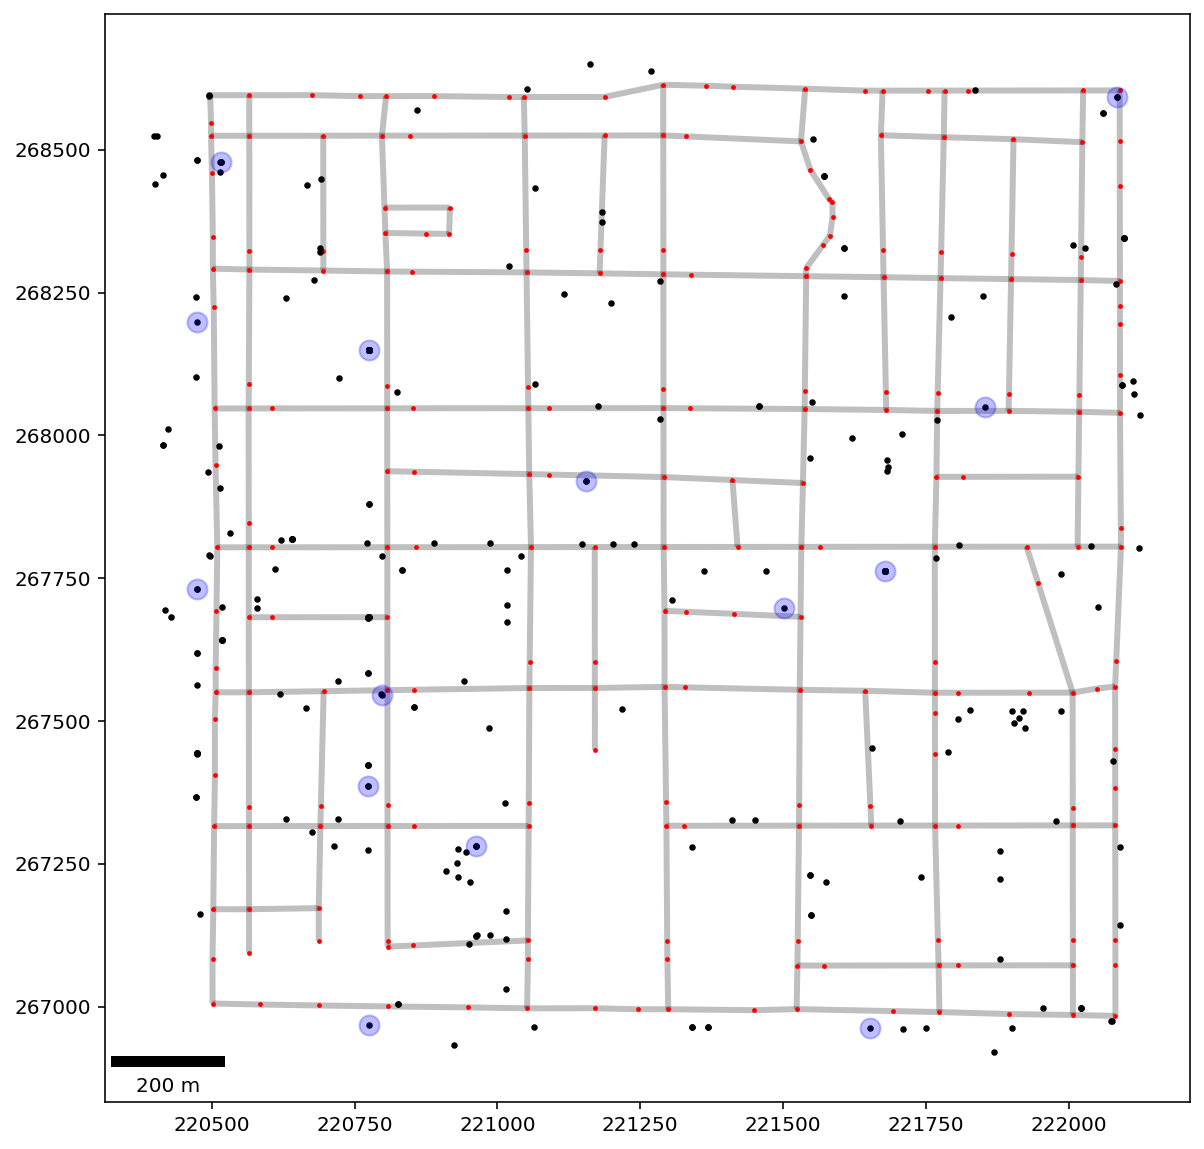

In [10]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
all_crimes.plot(ax=base, markersize=5, color="k", zorder=2)
crimes_scenes.plot(ax=base, markersize=100, alpha=0.25, color="blue", zorder=2)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

#### Associate Detective Königsberg's cases with the network and plot

In [11]:
ntw.snapobservations(crimes_scenes, "crime_scenes")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes", snapped=True)
pp_obs_snapped

,id,geometry,comp_label
0,0,POINT (221652.937 266993.226),0
1,1,POINT (220775.569 267001.039),0
2,2,POINT (220962.537 267316.554),0
3,3,POINT (220807.668 267387.173),0
4,4,POINT (220797.239 267554.033),0
5,5,POINT (221500.788 267683.891),0
6,6,POINT (220508.813 267730.837),0
7,7,POINT (221677.895 267805.108),0
8,8,POINT (221154.800 267930.187),0
9,9,POINT (221853.503 268043.032),0


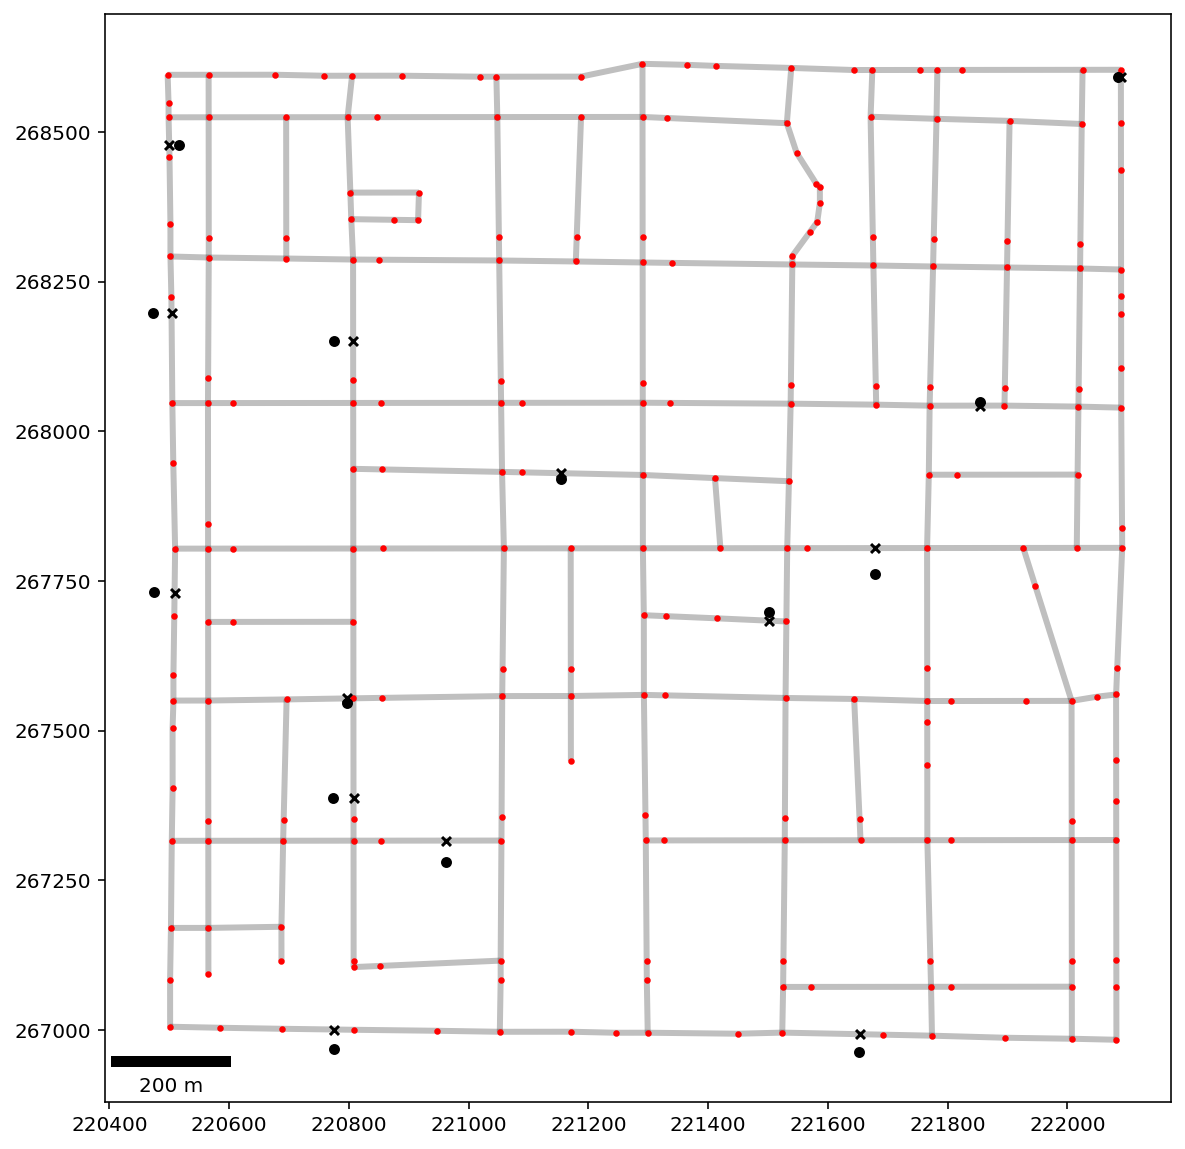

In [12]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=20, marker="x", color="k", zorder=2)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

#### Calculate distance matrix while generating shortest path trees

In [13]:
d2d_dist, tree = ntw.allneighbordistances("crime_scenes", gen_tree=True)
d2d_dist[:3, :3]

array([[          nan,  877.47303775, 1012.61325634],
       [ 877.47303775,           nan,  688.11683524],
       [1012.61325634,  688.11683524,           nan]])

In [14]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 1), (164, 158)),
  ((0, 2), (164, 142)),
  ((0, 3), (164, 197)),
  ((0, 4), (164, 147))],
 [((10, 13), (72, 98)),
  ((11, 12), (26, 29)),
  ((11, 13), (26, 85)),
  ((12, 13), (30, 85))])

--------------------------------
### 3. The Travling Salesperson Problem
#### Create decision variables for the crime scene locations

In [15]:
pp_obs["dv"] = pp_obs["id"].apply(lambda _id: "x_%s" % _id)
pp_obs

,id,geometry,comp_label,dv
0,0,POINT (221652.328 266963.169),0,x_0
1,1,POINT (220775.113 266968.350),0,x_1
2,2,POINT (220962.565 267281.381),0,x_2
3,3,POINT (220772.979 267387.147),0,x_3
4,4,POINT (220797.363 267546.558),0,x_4
5,5,POINT (221501.452 267698.654),0,x_5
6,6,POINT (220474.580 267731.267),0,x_6
7,7,POINT (221677.932 267762.053),0,x_7
8,8,POINT (221154.590 267920.549),0,x_8
9,9,POINT (221853.497 268049.786),0,x_9


#### Solve the TSP

In [16]:
mtz_tsp = MTZ_TSP(pp_obs["dv"], d2d_dist)

x_0,1: 1.0
x_1,2: 1.0
x_10,8: 1.0
x_11,12: 1.0
x_12,10: 1.0
x_13,7: 1.0
x_2,3: 1.0
x_3,4: 1.0
x_4,6: 1.0
x_5,0: 1.0
x_6,11: 1.0
x_7,5: 1.0
x_8,9: 1.0
x_9,13: 1.0
Status: Optimal


####  Extract all network shortest paths

In [17]:
paths = ntw.shortest_paths(tree, "crime_scenes")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,geometry,O,D,id
0,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,1,"(0, 1)"
1,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,2,"(0, 2)"
2,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,3,"(0, 3)"
3,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,4,"(0, 4)"
4,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,5,"(0, 5)"


####  Extract the tour

In [18]:
tour = mtz_tsp.extract_tour(paths_gdf.copy(), "id")
tour.head()

,geometry,O,D,id,leg
0,"LINESTRING (221652.937 266993.226, 221523.786 ...",0,1,"(0, 1)",0
13,"LINESTRING (220775.569 267001.039, 220807.966 ...",1,2,"(1, 2)",1
25,"LINESTRING (220962.537 267316.554, 220853.585 ...",2,3,"(2, 3)",2
36,"LINESTRING (220807.668 267387.173, 220807.540 ...",3,4,"(3, 4)",3
47,"LINESTRING (220797.239 267554.033, 220695.934 ...",4,6,"(4, 6)",4


#### Define label helper functions and plot Det. Königsberg's optimal tour

In [19]:
def tour_labels(t, b):
    """Label each leg of the tour."""

    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]

    kws = {"size": 20, "ha": "center", "va": "bottom", "weight": "bold"}
    t.apply(lambda x: b.annotate(text=x.leg, xy=_lab_loc(x), **kws), axis=1)


def obs_labels(o, b):
    """Label each point pattern observation."""

    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]

    kws = {"size": 14, "ha": "left", "va": "bottom", "style": "oblique", "color": "k"}
    o.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

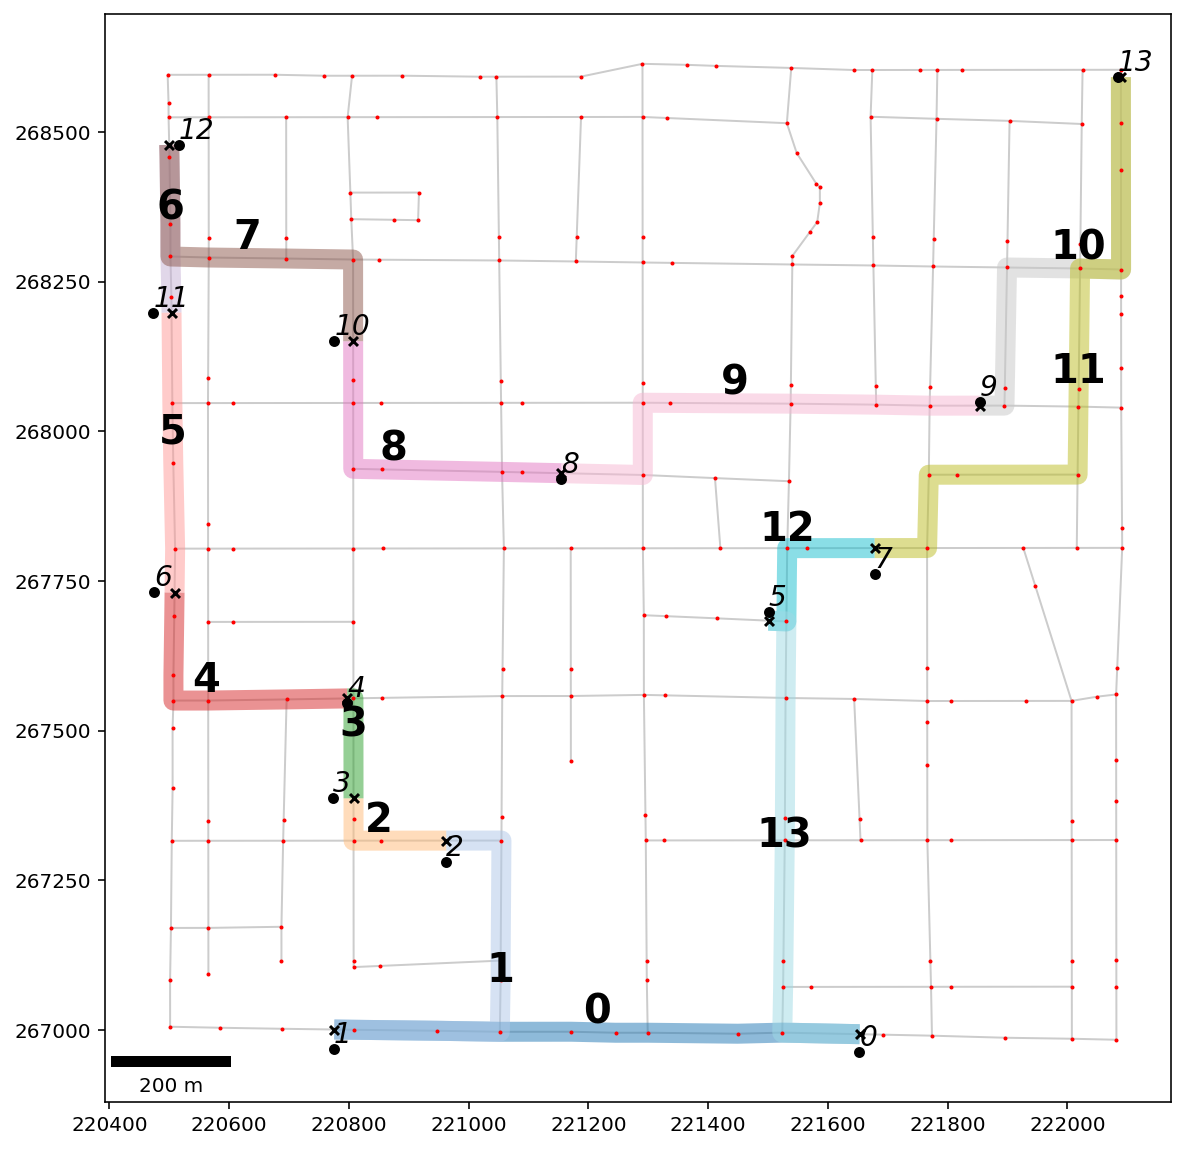

In [20]:
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
tour.plot(ax=base, column="leg", cmap="tab20", alpha=0.50, linewidth=10, zorder=1)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=3)
pp_obs_snapped.plot(ax=base, markersize=20, color="k", marker="x", zorder=2)
# tour leg labels
tour_labels(tour, base)
# crime scene labels
obs_labels(pp_obs, base)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

----------------------